## F

In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from utils import *
np.random.seed(0)

#
#
noise_percent = 5
trained = True
critical = [0,0,0]
    
initialp = [1,1,1]
xp = [1,0,0]
xm = [-1,0,0]
yp = [0,1,0]
ym = [0,-1,0]
zp = [0,0,1]
zm = [0,0,-1]

initial = [critical[i]+initialp[i] for i in list(range(len(critical)))]
initialxp = [initial[i]+xp[i] for i in list(range(len(initial)))]
initialxm = [initial[i]+xm[i] for i in list(range(len(initial)))]
initialyp = [initial[i]+yp[i] for i in list(range(len(initial)))]
initialym = [initial[i]+ym[i] for i in list(range(len(initial)))]
initialzp = [initial[i]+zp[i] for i in list(range(len(initial)))]
initialzm = [initial[i]+zm[i] for i in list(range(len(initial)))]

#
#

Populating the interactive namespace from numpy and matplotlib


### Generate data

C:\Users\Willi\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


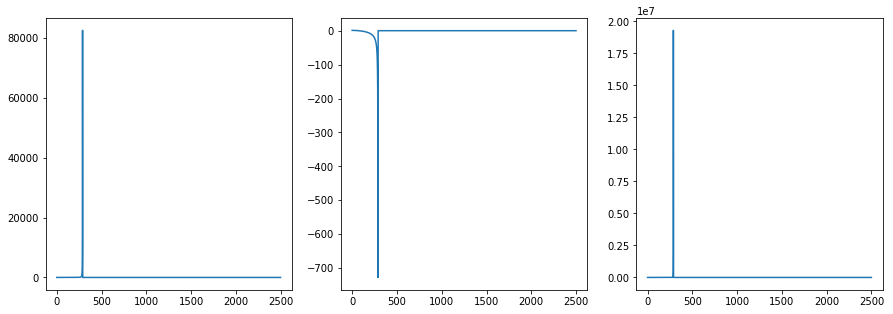

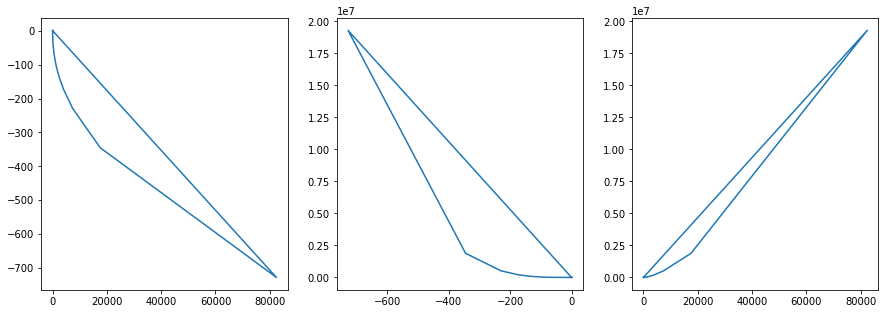

In [2]:
def F(X, t):
    
    x,y,z = X

    return [y+z, -x+0.5*y, x*x-z]

M = 25000
subsample_rate = 10

subsample = [j for j in range(M) if j%subsample_rate == 0]
m = len(subsample)

t = np.linspace(0,25,M+1)[:-1]; dt = (t[1]-t[0])*subsample_rate

X = odeint(F, initial, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
x = X[0,:]; y = X[1,:]; z = X[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(x)
subplot(1,3,2); plot(y)
subplot(1,3,3); plot(z)
figure()
subplot(1,3,1); plot(x, y)
subplot(1,3,2); plot(y, z)
subplot(1,3,3); plot(x, z)

In [14]:
X.shape

(3, 2500)

In [3]:
n = X.shape[0]
noise_level = [0.01*noise_percent*np.std(X[j,:]) for j in range(n)]
measurement_noise = np.vstack([noise_level[j]*np.random.randn(m) for j in range(n)])

Y = X + measurement_noise

In [4]:
N_hat, X_hat = approximate_noise(Y, lam = 1e2)

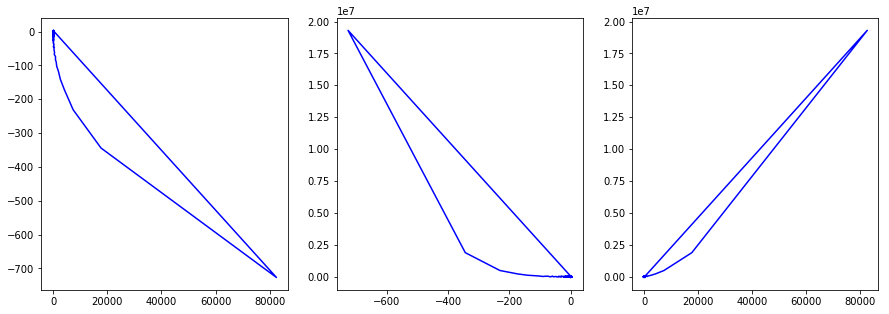

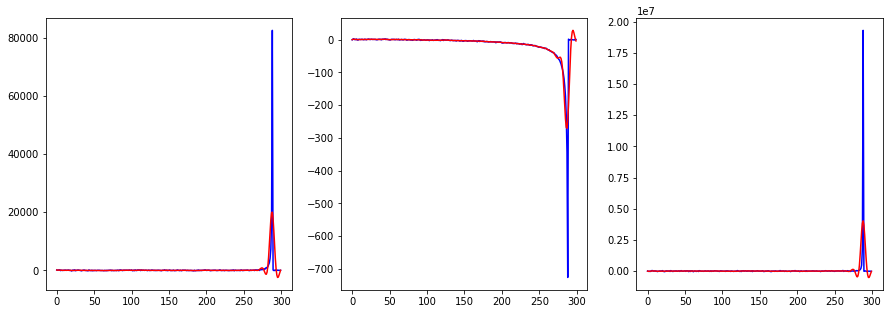

In [5]:
figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:], Y[1,:], 'b')
subplot(1,3,2); plot(Y[1,:], Y[2,:], 'b')
subplot(1,3,3); plot(Y[0,:], Y[2,:], 'b')

figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:300],'b'); plot(X_hat[0,:300],'r')
subplot(1,3,2); plot(Y[1,:300],'b'); plot(X_hat[1,:300],'r')
subplot(1,3,3); plot(Y[2,:300],'b'); plot(X_hat[2,:300],'r')

### Train 

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
saver = tf.train.Saver()

if trained: 
    saver.restore(sess, "./saved_sessionsF/F.ckpt")
    
else:

    num_dt = 10

    feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
                 placeholders['T_0']: (np.arange(m-2*num_dt)*dt).reshape(1,m-2*num_dt),
                 placeholders['h']: np.array([[dt]])}

    for j in range(num_dt):
        feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
        feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

    optimizer.minimize(sess, feed_dict=feed_dict)
    
    saver = tf.train.Saver()
    saver.save(sess,"./saved_sessionsF/F.ckpt")
    trained = True
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


In [8]:
X_test = np.zeros((3,5*m))
X_test[:,0] = X[:,0]

weights, biases, N = net_params

x_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

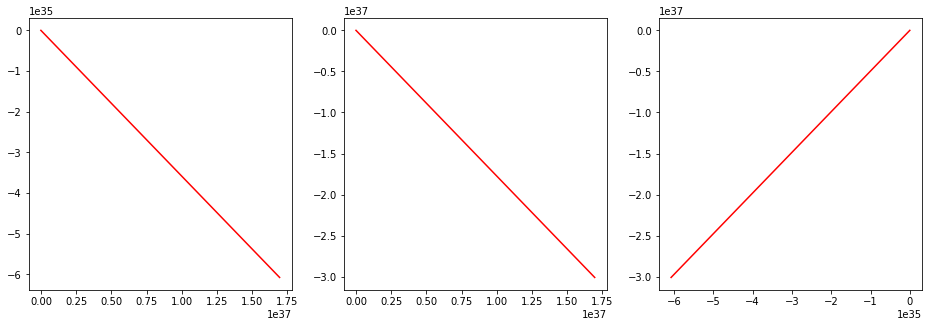

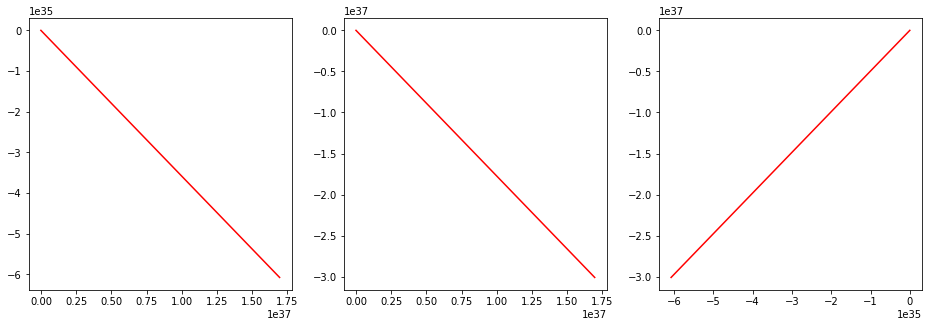

In [9]:
figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:m],X_test[1,:m],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:m],X_test[2,:m],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:m],X_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:],X_test[1,:],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:],X_test[2,:],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:],X_test[2,:],'r')

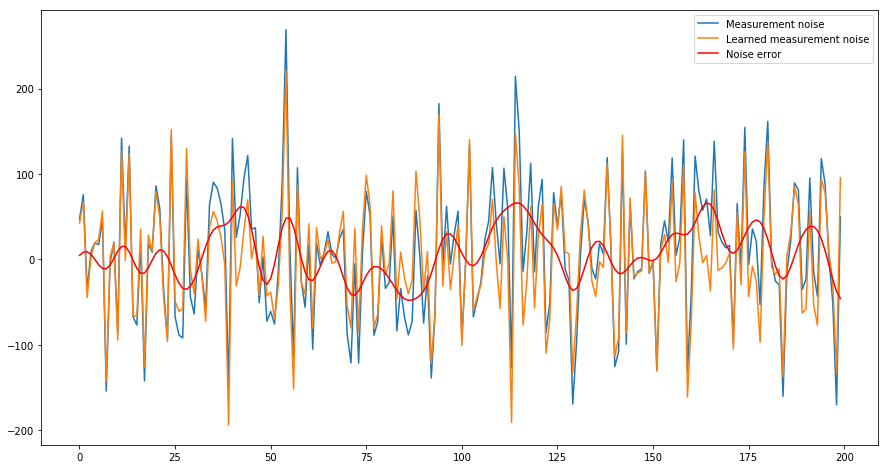

In [10]:
start = 1000
end = 1200

figure(figsize = (15,8))

plot(measurement_noise[0,start:end], label = 'Measurement noise')
plot(N.eval()[0,start:end], label = 'Learned measurement noise')
plot(measurement_noise[0,start:end] - N.eval()[0,start:end], 'r', label = 'Noise error')
legend(loc='upper right')

## Generate Data for X plus (xp)

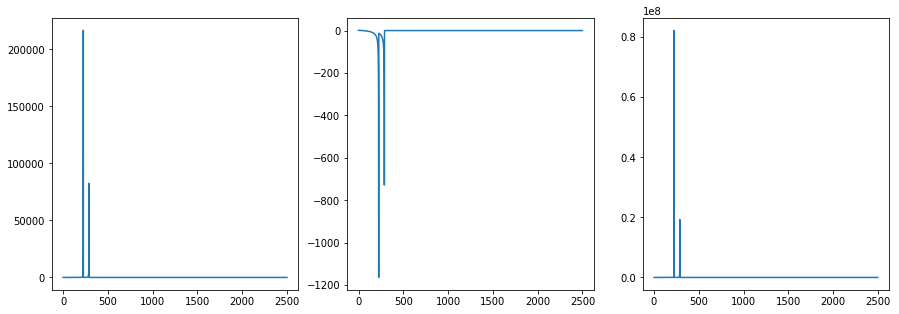

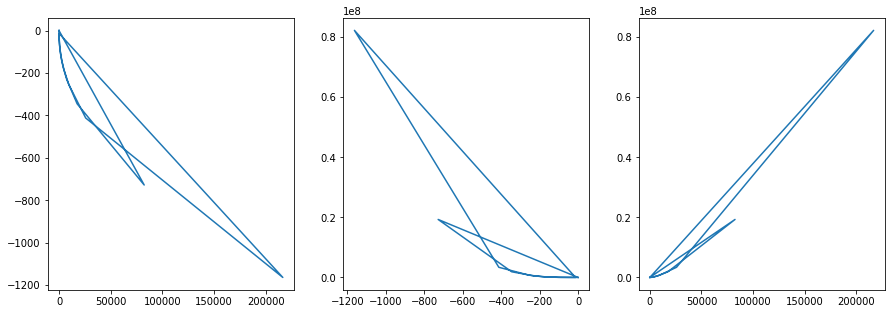

In [13]:
Xxp = odeint(F, initialxp, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xxp = Xxp[0,:]; yxp = Xxp[1,:]; zxp = Xxp[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xxp)
subplot(1,3,2); plot(yxp)
subplot(1,3,3); plot(zxp)
figure()
subplot(1,3,1); plot(xxp, yxp)
subplot(1,3,2); plot(yxp, zxp)
subplot(1,3,3); plot(xxp, zxp)

In [14]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

C:\Users\Willi\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [15]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xxp_test = np.zeros((3,5*m))
Xxp_test[:,0] = Xxp[:,0]

weights, biases, N = net_params

xxp_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xxp_test[:,j+1] = sess.run(xxp_next_test, feed_dict={placeholders['Y_0']: np.array([Xxp_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


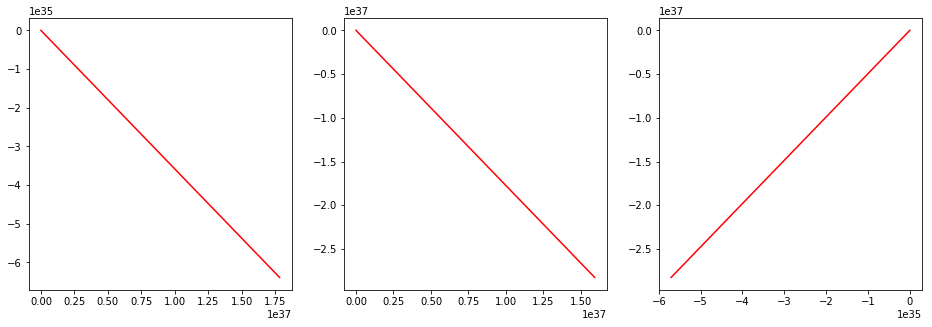

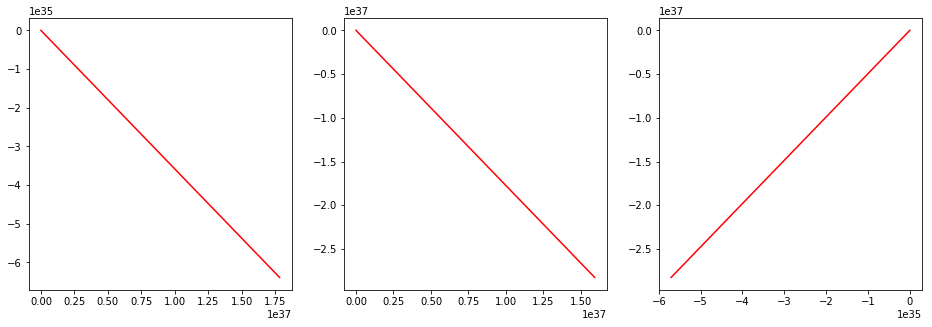

In [16]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xxp[0,:m],Xxp[1,:m],'b'); plot(Xxp_test[0,:m],Xxp_test[1,:m],'r')
subplot(1,3,2); plot(Xxp[0,:m],Xxp[2,:m],'b'); plot(Xxp_test[0,:m],Xxp_test[2,:m],'r')
subplot(1,3,3); plot(Xxp[1,:m],Xxp[2,:m],'b'); plot(Xxp_test[1,:m],Xxp_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xxp[0,:m],Xxp[1,:m],'b'); plot(Xxp_test[0,:],Xxp_test[1,:],'r')
subplot(1,3,2); plot(Xxp[0,:m],Xxp[2,:m],'b'); plot(Xxp_test[0,:],Xxp_test[2,:],'r')
subplot(1,3,3); plot(Xxp[1,:m],Xxp[2,:m],'b'); plot(Xxp_test[1,:],Xxp_test[2,:],'r')

## Generate Data for X minus (xm)

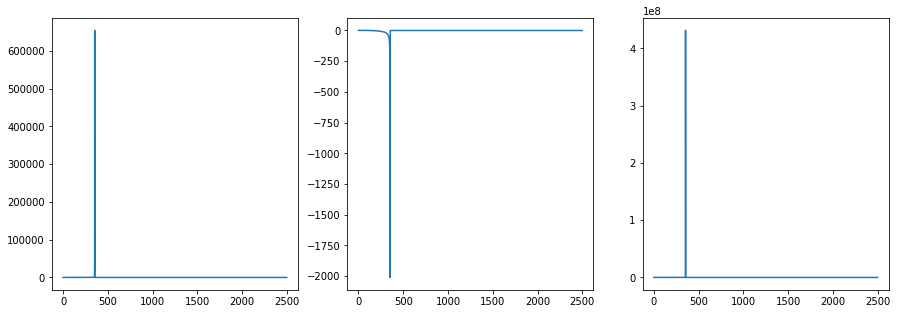

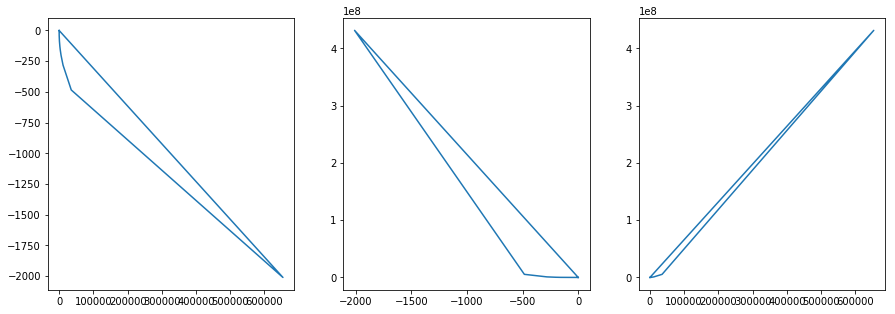

In [17]:
Xxm = odeint(F, initialxm, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xxm = Xxm[0,:]; yxm = Xxm[1,:]; zxm = Xxm[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xxm)
subplot(1,3,2); plot(yxm)
subplot(1,3,3); plot(zxm)
figure()
subplot(1,3,1); plot(xxm, yxm)
subplot(1,3,2); plot(yxm, zxm)
subplot(1,3,3); plot(xxm, zxm)

In [18]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [19]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xxm_test = np.zeros((3,5*m))
Xxm_test[:,0] = Xxm[:,0]

weights, biases, N = net_params

xxm_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xxm_test[:,j+1] = sess.run(xxm_next_test, feed_dict={placeholders['Y_0']: np.array([Xxm_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


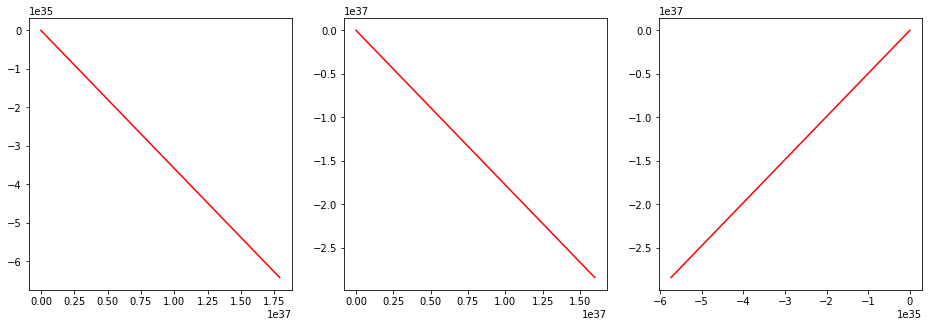

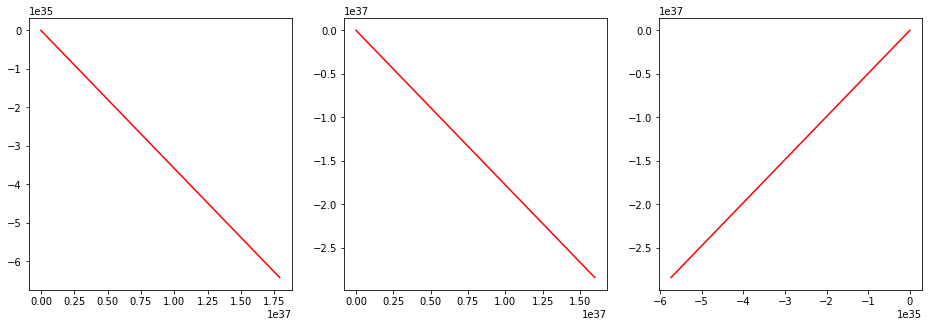

In [20]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xxm[0,:m],Xxm[1,:m],'b'); plot(Xxm_test[0,:m],Xxm_test[1,:m],'r')
subplot(1,3,2); plot(Xxm[0,:m],Xxm[2,:m],'b'); plot(Xxm_test[0,:m],Xxm_test[2,:m],'r')
subplot(1,3,3); plot(Xxm[1,:m],Xxm[2,:m],'b'); plot(Xxm_test[1,:m],Xxm_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xxm[0,:m],Xxm[1,:m],'b'); plot(Xxm_test[0,:],Xxm_test[1,:],'r')
subplot(1,3,2); plot(Xxm[0,:m],Xxm[2,:m],'b'); plot(Xxm_test[0,:],Xxm_test[2,:],'r')
subplot(1,3,3); plot(Xxm[1,:m],Xxm[2,:m],'b'); plot(Xxm_test[1,:],Xxm_test[2,:],'r')

## Generate Data for Y plus (yp)

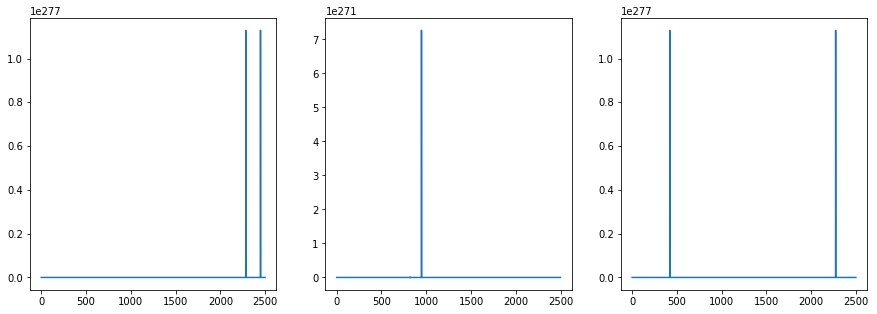

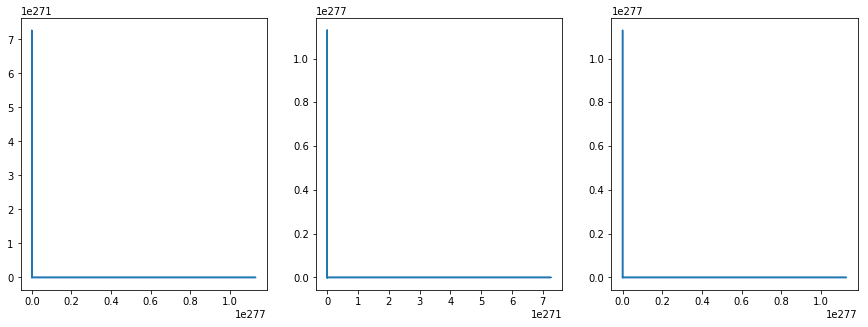

In [21]:
Xyp = odeint(F, initialyp, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xyp = Xyp[0,:]; yyp = Xyp[1,:]; zyp = Xyp[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xyp)
subplot(1,3,2); plot(yyp)
subplot(1,3,3); plot(zyp)
figure()
subplot(1,3,1); plot(xyp, yyp)
subplot(1,3,2); plot(yyp, zyp)
subplot(1,3,3); plot(xyp, zyp)

In [22]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [23]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xyp_test = np.zeros((3,5*m))
Xyp_test[:,0] = Xyp[:,0]

weights, biases, N = net_params

xyp_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xyp_test[:,j+1] = sess.run(xyp_next_test, feed_dict={placeholders['Y_0']: np.array([Xyp_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


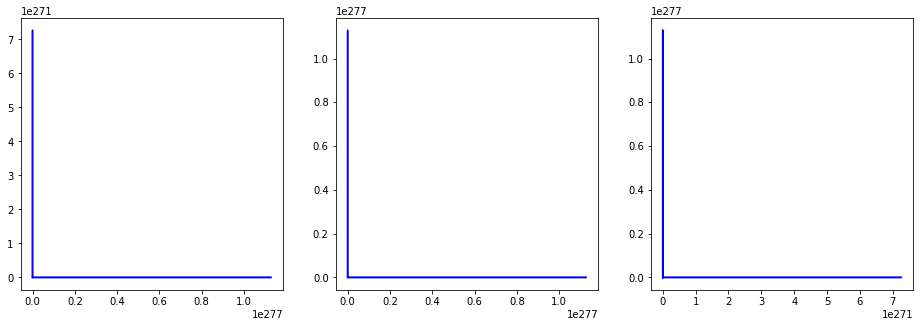

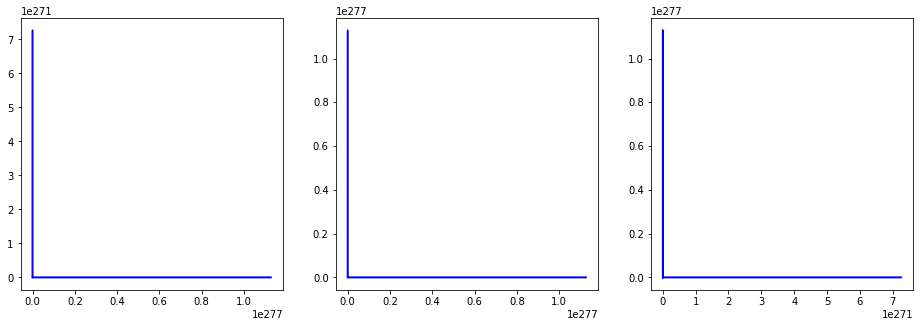

In [24]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xyp[0,:m],Xyp[1,:m],'b'); plot(Xyp_test[0,:m],Xyp_test[1,:m],'r')
subplot(1,3,2); plot(Xyp[0,:m],Xyp[2,:m],'b'); plot(Xyp_test[0,:m],Xyp_test[2,:m],'r')
subplot(1,3,3); plot(Xyp[1,:m],Xyp[2,:m],'b'); plot(Xyp_test[1,:m],Xyp_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xyp[0,:m],Xyp[1,:m],'b'); plot(Xyp_test[0,:],Xyp_test[1,:],'r')
subplot(1,3,2); plot(Xyp[0,:m],Xyp[2,:m],'b'); plot(Xyp_test[0,:],Xyp_test[2,:],'r')
subplot(1,3,3); plot(Xyp[1,:m],Xyp[2,:m],'b'); plot(Xyp_test[1,:],Xyp_test[2,:],'r')

## Generate Data for Y minus (ym)

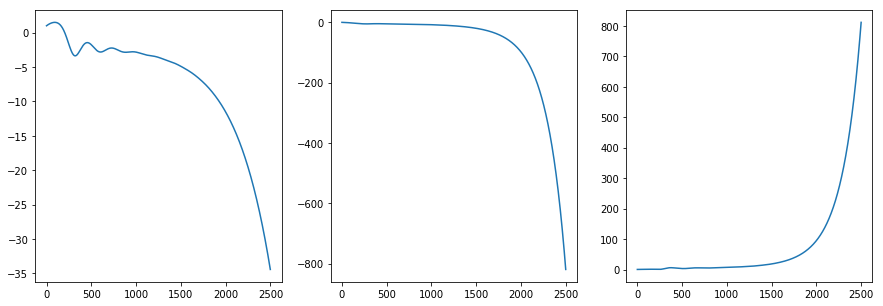

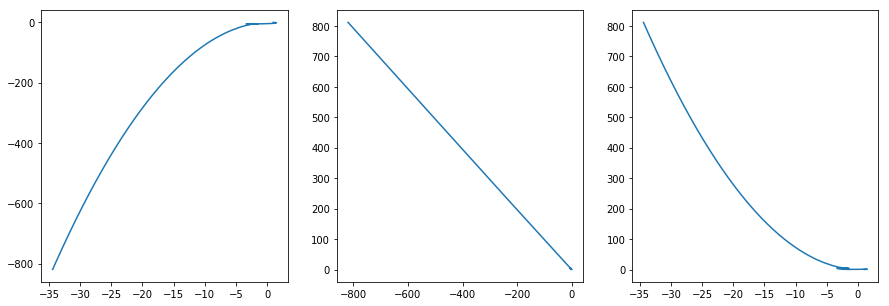

In [25]:
Xym = odeint(F, initialym, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xym = Xym[0,:]; yym = Xym[1,:]; zym = Xym[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xym)
subplot(1,3,2); plot(yym)
subplot(1,3,3); plot(zym)
figure()
subplot(1,3,1); plot(xym, yym)
subplot(1,3,2); plot(yym, zym)
subplot(1,3,3); plot(xym, zym)

In [26]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [27]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xym_test = np.zeros((3,5*m))
Xym_test[:,0] = Xym[:,0]

weights, biases, N = net_params

xym_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xym_test[:,j+1] = sess.run(xym_next_test, feed_dict={placeholders['Y_0']: np.array([Xym_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


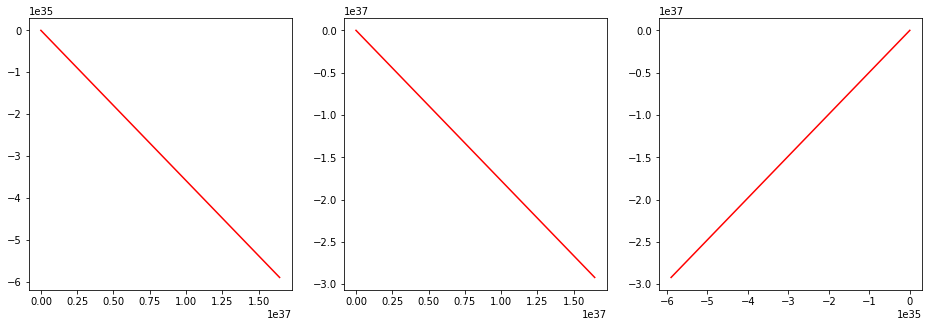

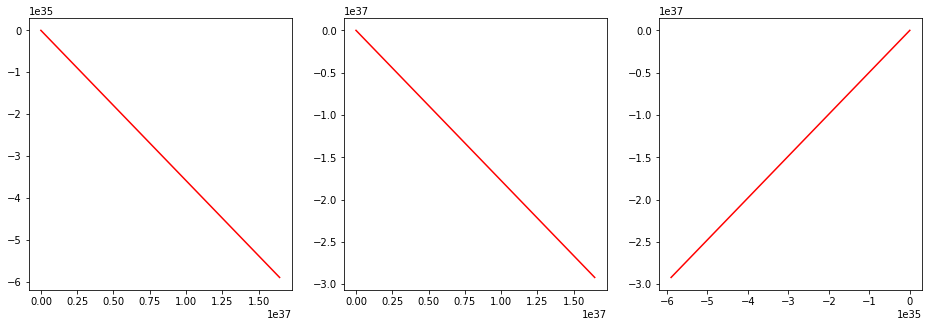

In [28]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xym[0,:m],Xym[1,:m],'b'); plot(Xym_test[0,:m],Xym_test[1,:m],'r')
subplot(1,3,2); plot(Xym[0,:m],Xym[2,:m],'b'); plot(Xym_test[0,:m],Xym_test[2,:m],'r')
subplot(1,3,3); plot(Xym[1,:m],Xym[2,:m],'b'); plot(Xym_test[1,:m],Xym_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xym[0,:m],Xym[1,:m],'b'); plot(Xym_test[0,:],Xym_test[1,:],'r')
subplot(1,3,2); plot(Xym[0,:m],Xym[2,:m],'b'); plot(Xym_test[0,:],Xym_test[2,:],'r')
subplot(1,3,3); plot(Xym[1,:m],Xym[2,:m],'b'); plot(Xym_test[1,:],Xym_test[2,:],'r')

## Generate Data for Z plus (zp)

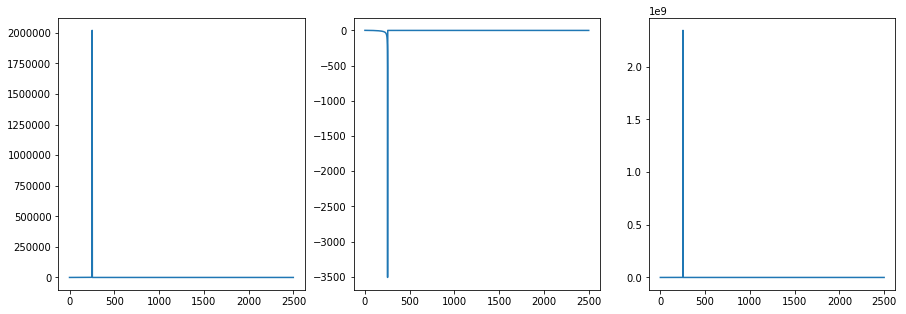

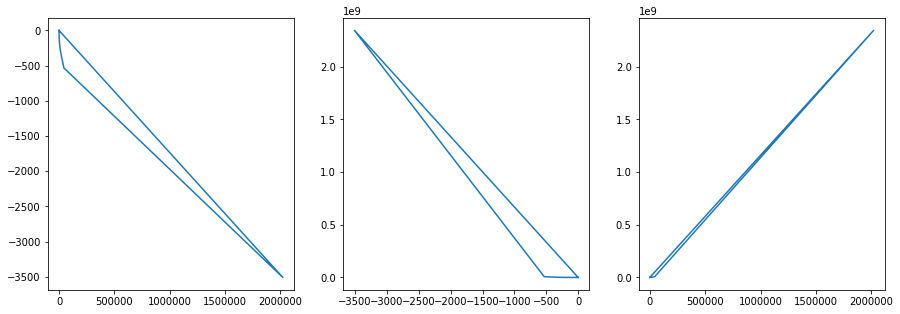

In [29]:
Xzp = odeint(F, initialzp, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xzp = Xzp[0,:]; yzp = Xzp[1,:]; zzp = Xzp[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xzp)
subplot(1,3,2); plot(yzp)
subplot(1,3,3); plot(zzp)
figure()
subplot(1,3,1); plot(xzp, yzp)
subplot(1,3,2); plot(yzp, zzp)
subplot(1,3,3); plot(xzp, zzp)

In [30]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [31]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xzp_test = np.zeros((3,5*m))
Xzp_test[:,0] = Xzp[:,0]

weights, biases, N = net_params

xzp_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xzp_test[:,j+1] = sess.run(xzp_next_test, feed_dict={placeholders['Y_0']: np.array([Xzp_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


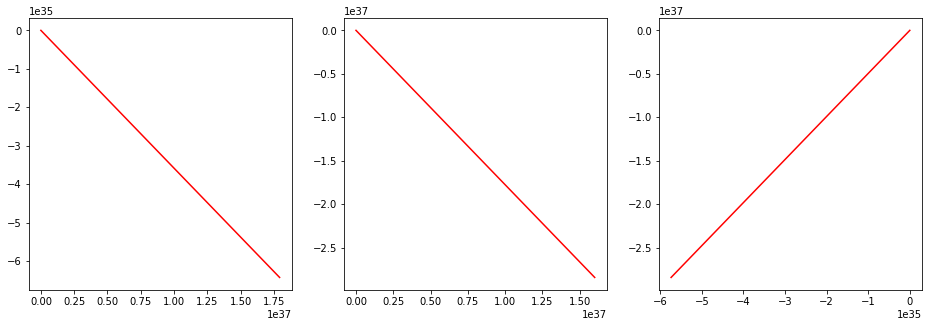

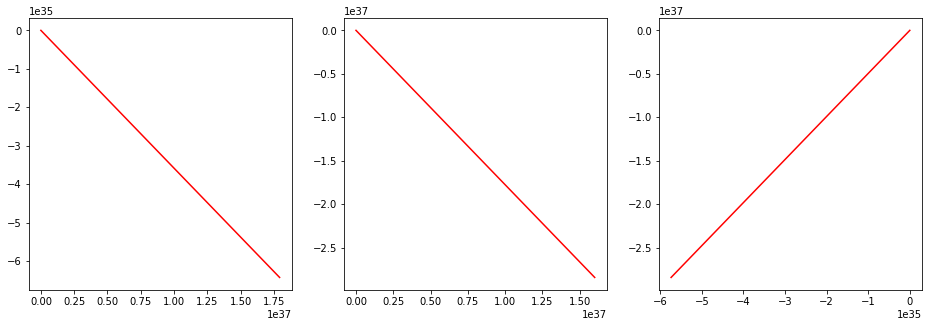

In [32]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xzp[0,:m],Xzp[1,:m],'b'); plot(Xzp_test[0,:m],Xzp_test[1,:m],'r')
subplot(1,3,2); plot(Xzp[0,:m],Xzp[2,:m],'b'); plot(Xzp_test[0,:m],Xzp_test[2,:m],'r')
subplot(1,3,3); plot(Xzp[1,:m],Xzp[2,:m],'b'); plot(Xzp_test[1,:m],Xzp_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xzp[0,:m],Xzp[1,:m],'b'); plot(Xzp_test[0,:],Xzp_test[1,:],'r')
subplot(1,3,2); plot(Xzp[0,:m],Xzp[2,:m],'b'); plot(Xzp_test[0,:],Xzp_test[2,:],'r')
subplot(1,3,3); plot(Xzp[1,:m],Xzp[2,:m],'b'); plot(Xzp_test[1,:],Xzp_test[2,:],'r')

## Generate Data for Z minus (zm)

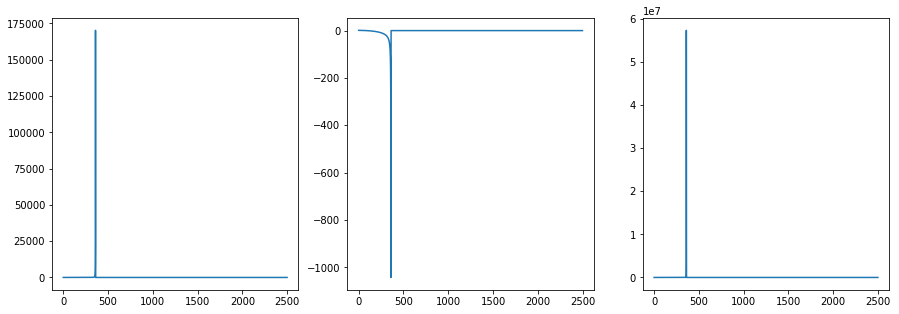

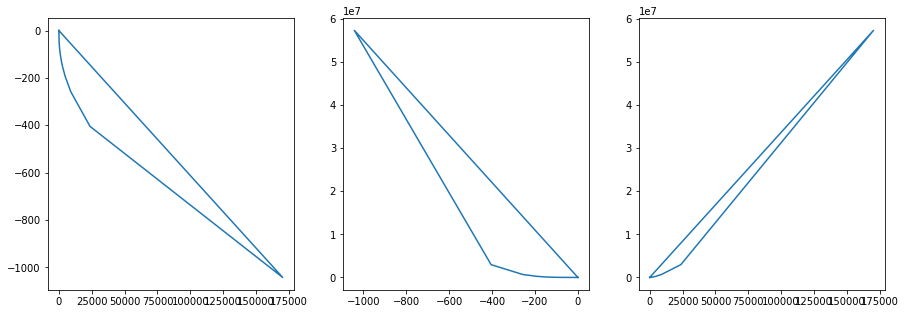

In [33]:
Xzm = odeint(F, initialzm, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xzm = Xzm[0,:]; yzm = Xzm[1,:]; zzm = Xzm[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xzm)
subplot(1,3,2); plot(yzm)
subplot(1,3,3); plot(zzm)
figure()
subplot(1,3,1); plot(xzm, yzm)
subplot(1,3,2); plot(yzm, zzm)
subplot(1,3,3); plot(xzm, zzm)

In [34]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [35]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xzm_test = np.zeros((3,5*m))
Xzm_test[:,0] = Xzm[:,0]

weights, biases, N = net_params

xzm_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xzm_test[:,j+1] = sess.run(xzm_next_test, feed_dict={placeholders['Y_0']: np.array([Xzm_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


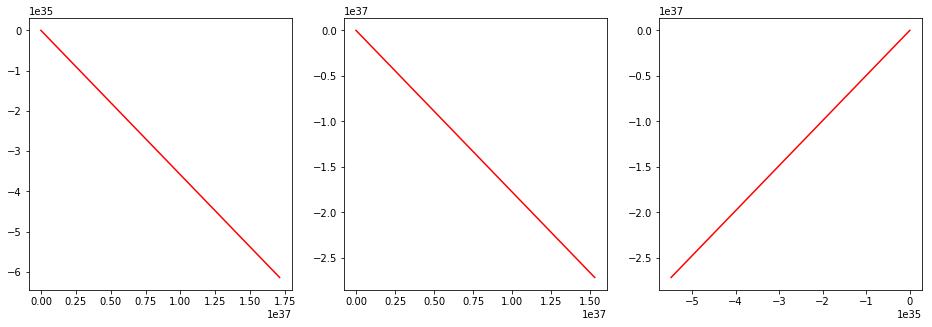

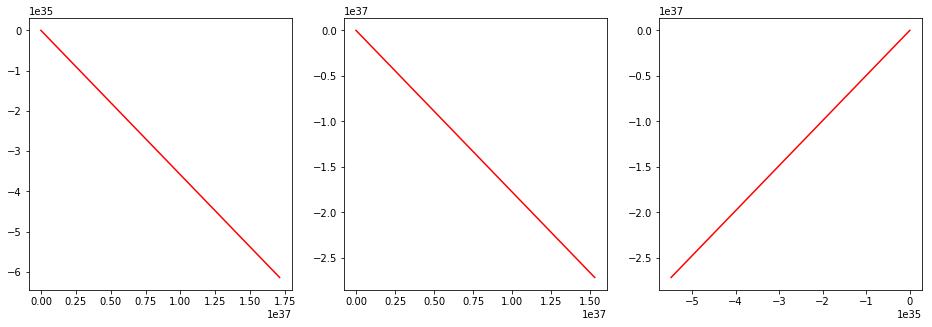

In [36]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xzm[0,:m],Xzm[1,:m],'b'); plot(Xzm_test[0,:m],Xzm_test[1,:m],'r')
subplot(1,3,2); plot(Xzm[0,:m],Xzm[2,:m],'b'); plot(Xzm_test[0,:m],Xzm_test[2,:m],'r')
subplot(1,3,3); plot(Xzm[1,:m],Xzm[2,:m],'b'); plot(Xzm_test[1,:m],Xzm_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xzm[0,:m],Xzm[1,:m],'b'); plot(Xzm_test[0,:],Xzm_test[1,:],'r')
subplot(1,3,2); plot(Xzm[0,:m],Xzm[2,:m],'b'); plot(Xzm_test[0,:],Xzm_test[2,:],'r')
subplot(1,3,3); plot(Xzm[1,:m],Xzm[2,:m],'b'); plot(Xzm_test[1,:],Xzm_test[2,:],'r')

## Generate Data for Crtitical

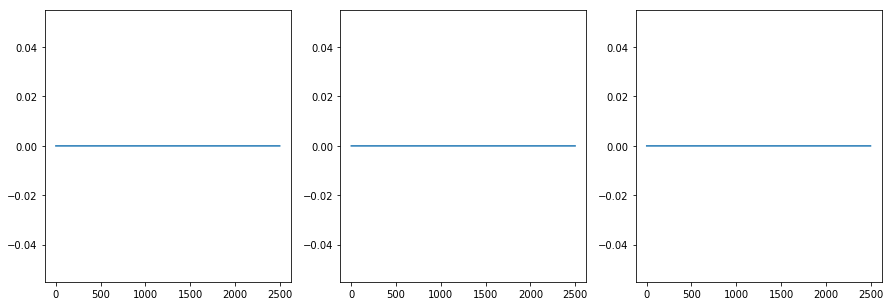

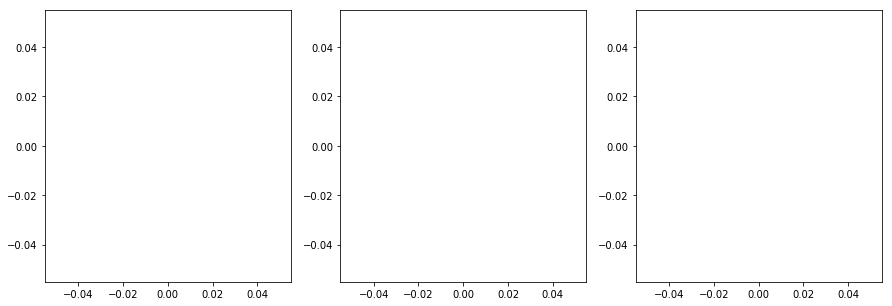

In [37]:
Xc = odeint(F, critical, t, rtol = 1e-12, atol = 1e-12)[subsample, :].T
xc = Xc[0,:]; yc = Xc[1,:]; zc = Xc[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(xc)
subplot(1,3,2); plot(yc)
subplot(1,3,3); plot(zc)
figure()
subplot(1,3,1); plot(xc, yc)
subplot(1,3,2); plot(yc, zc)
subplot(1,3,3); plot(xc, zc)

In [38]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [39]:
saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

Xc_test = np.zeros((3,5*m))
Xc_test[:,0] = Xc[:,0]

weights, biases, N = net_params

xc_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    Xc_test[:,j+1] = sess.run(xc_next_test, feed_dict={placeholders['Y_0']: np.array([Xc_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


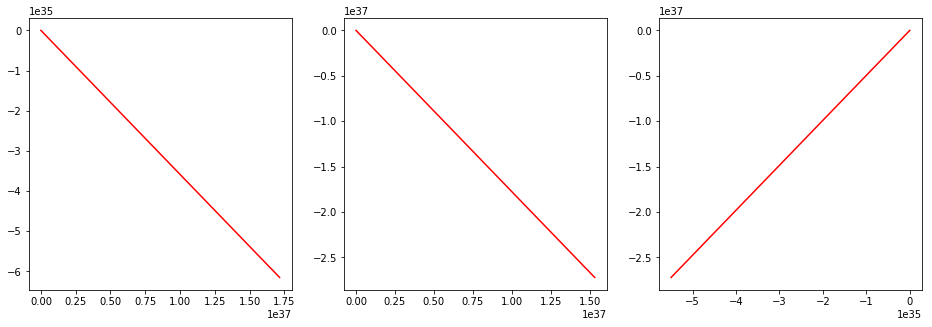

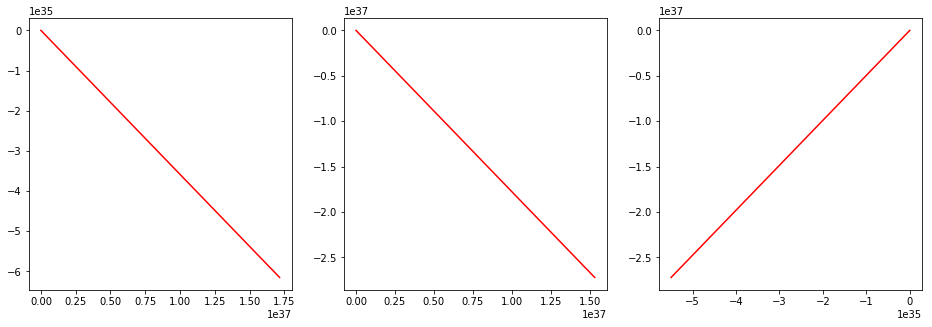

In [40]:
figure(figsize=(16,5))
subplot(1,3,1); plot(Xc[0,:m],Xc[1,:m],'b'); plot(Xc_test[0,:m],Xc_test[1,:m],'r')
subplot(1,3,2); plot(Xc[0,:m],Xc[2,:m],'b'); plot(Xc_test[0,:m],Xc_test[2,:m],'r')
subplot(1,3,3); plot(Xc[1,:m],Xc[2,:m],'b'); plot(Xc_test[1,:m],Xc_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(Xc[0,:m],Xc[1,:m],'b'); plot(Xc_test[0,:],Xc_test[1,:],'r')
subplot(1,3,2); plot(Xc[0,:m],Xc[2,:m],'b'); plot(Xc_test[0,:],Xc_test[2,:],'r')
subplot(1,3,3); plot(Xc[1,:m],Xc[2,:m],'b'); plot(Xc_test[1,:],Xc_test[2,:],'r')

## Calculate Errors

In [41]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()
saver.restore(sess, "./saved_sessionsF/F.ckpt")

INFO:tensorflow:Restoring parameters from ./saved_sessionsF/F.ckpt


In [42]:
weights, biases, N = net_params

true_vector_field = np.stack([y+z, -x+0.5*y, x*x-z], axis = 0)
approx_vec_field = sess.run(simple_net(placeholders['Y_0'], weights, biases), feed_dict = {placeholders['Y_0']: X})

noise_error = np.linalg.norm(measurement_noise - N.eval(),'fro')**2 / m
vector_field_error = np.linalg.norm(true_vector_field - approx_vec_field,'fro')**2 / np.linalg.norm(true_vector_field,'fro')**2

print(noise_error)
print(vector_field_error)

111526330383.07838
1.0057323262400184


## Save Plots

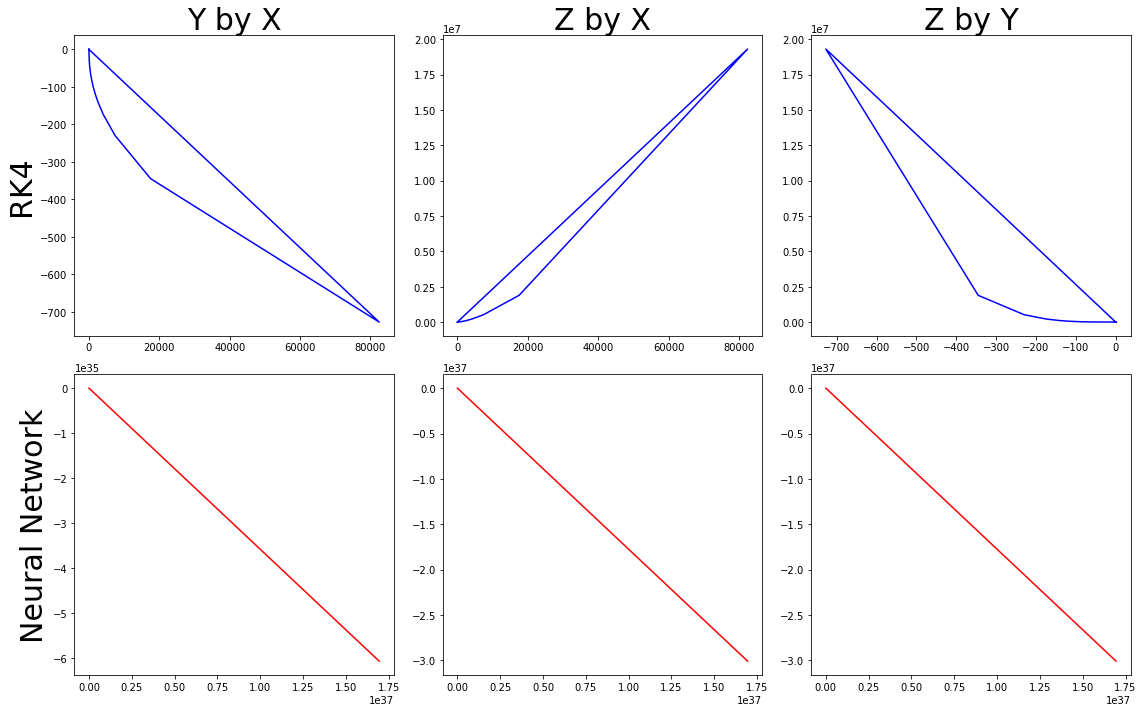

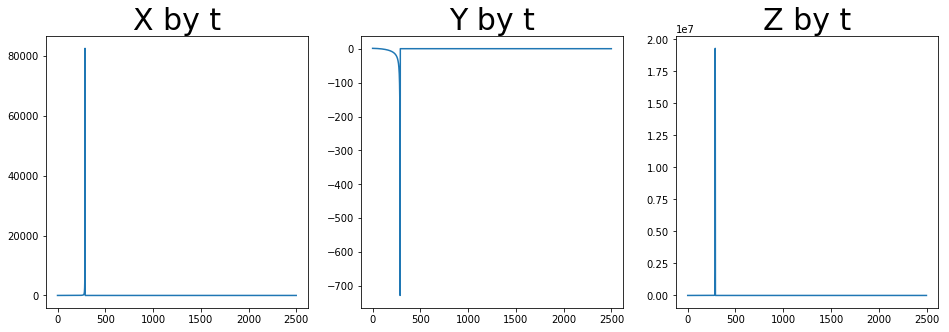

In [13]:
figpath = 'C:/Users/Willi/Documents/NYU/2019 Fall/Machine Learning/Final Project/Figures/'

fsize = 30

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(16,10))
    
plt.subplot(2,3,1); plot(X[0,:m],X[1,:m],'b')
plt.title('Y by X',fontsize = fsize)
plt.ylabel('RK4',fontsize = fsize)
plt.subplot(2,3,2); plot(X[0,:m],X[2,:m],'b')
plt.title('Z by X',fontsize = fsize)
plt.subplot(2,3,3); plot(X[1,:m],X[2,:m],'b')
plt.title('Z by Y',fontsize = fsize)

plt.subplot(2,3,4); plot(X_test[0,:m],X_test[1,:m],'r')
plt.ylabel('Neural Network',fontsize = fsize)
plt.subplot(2,3,5); plot(X_test[0,:m],X_test[2,:m],'r')
plt.subplot(2,3,6); plot(X_test[0,:m],X_test[2,:m],'r')

fig2, axes2 = plt.subplots(nrows = 2, ncols = 3, figsize=(16,5))

plt.subplot(1,3,1); plot(x)
plt.title('X by t',fontsize = fsize)
plt.subplot(1,3,2); plot(y)
plt.title('Y by t',fontsize = fsize)
plt.subplot(1,3,3); plot(z)
plt.title('Z by t',fontsize = fsize)

fig.tight_layout()
plt.show()
fig.savefig(figpath+'F_traj.png')
fig2.savefig(figpath+'F_ind.png')

## Break (Unmodified code below)

N_gaussian = N.eval()

if False: 
    saver = tf.train.Saver()
    saver.save(sess, "./saved_sessions/Lorenz_5_gaussian.ckpt")

true_vector_field = np.stack([10*(y-x), x*(28-z)-y, x*y-8/3*z], axis = 0)
approx_vec_field = sess.run(simple_net(placeholders['Y_0'], weights, biases), feed_dict = {placeholders['Y_0']: X})

noise_error = np.linalg.norm(measurement_noise - N.eval(),'fro')**2 / m
vector_field_error = np.linalg.norm(true_vector_field - approx_vec_field,'fro')**2 / np.linalg.norm(true_vector_field,'fro')**2

print(noise_error)
print(vector_field_error)

noise_level = 0.01*noise_percent*np.std(X)

measurement_noise_sdt = np.random.standard_t(10, size=(3,m))
measurement_noise_sdt = measurement_noise_sdt / np.std(measurement_noise_sdt)
measurement_noise_sdt = noise_level*measurement_noise_sdt

Y = X + measurement_noise_sdt
print(np.std(measurement_noise_sdt))

N_hat, X_hat = approximate_noise(Y, lam = 1e2)

figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:100],'b'); plot(X_hat[0,:100],'r')
subplot(1,3,2); plot(Y[1,:100],'b'); plot(X_hat[1,:100],'r')
subplot(1,3,3); plot(Y[2,:100],'b'); plot(X_hat[2,:100],'r')

### Train 

tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 64, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

num_dt = 10

feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
             placeholders['T_0']: (np.arange(m-2*num_dt)*dt).reshape(1,m-2*num_dt),
             placeholders['h']: np.array([[dt]])}

for j in range(num_dt):
    feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
    feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

optimizer.minimize(sess, feed_dict=feed_dict)

X_test = np.zeros((3,5*m))
X_test[:,0] = X[:,0]

weights, biases, N = net_params

x_next_test = RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

for j in range(5*m-1):
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:m],X_test[1,:m],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:m],X_test[2,:m],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:m],X_test[2,:m],'r')

figure(figsize=(16,5))
subplot(1,3,1); plot(X[0,:m],X[1,:m],'b'); plot(X_test[0,:],X_test[1,:],'r')
subplot(1,3,2); plot(X[0,:m],X[2,:m],'b'); plot(X_test[0,:],X_test[2,:],'r')
subplot(1,3,3); plot(X[1,:m],X[2,:m],'b'); plot(X_test[1,:],X_test[2,:],'r')

start = 1000
end = 1200

figure(figsize = (15,8))

plot(measurement_noise_sdt[0,start:end], label = 'Measurement noise')
plot(N.eval()[0,start:end], label = 'Learned measurement noise')
plot(measurement_noise_sdt[0,start:end] - N.eval()[0,start:end], 'r', label = 'Noise error')
legend(loc='upper right')

N_sdt = N.eval()

figure()

bins = numpy.linspace(-2.5, 2.5, 100)

subplot(1,2,1)
hist(N_gaussian.flatten(), bins, alpha=0.5, label='N_hat')
hist(measurement_noise.flatten(), bins, alpha=0.5, label='N_true')
legend(loc='upper right')
title('Learned distribution of Gaussian noise')

subplot(1,2,2)
hist(N_sdt.flatten(), bins, alpha=0.5, label='N_hat')
hist(measurement_noise_sdt.flatten(), bins, alpha=0.5, label='N_true')
legend(loc='upper right')
title('Learned distribution of Student\'s t noise')